In [3]:
# Author: Yangsong Gu 
# for COSC 522 project 5
# 11/23/2021

In [4]:
from steering_control import *
import numpy as np 
import pandas as pd
import time
import os
import sys
import pickle

In [5]:
import numpy as np
from world import World
from agents import Car, RingBuilding, CircleBuilding, Painting, Pedestrian
from geometry import Point
import time
from tkinter import *
from steering_control import *

### Initialization

In [3]:


# dt = 0.1 # time steps in terms of seconds. In other words, 1/dt is the FPS.
# world_width = 120 # in meters
# world_height = 120
# inner_building_radius = 30
# num_lanes = 2
# lane_marker_width = 0.5
# num_of_lane_markers = 50
# lane_width = 3.5

## instantiate the object

In [73]:
# w = World(dt, width = world_width, height = world_height, ppm = 6) # The world is 120 meters by 120 meters. ppm is the pixels per meter.

In [74]:
# # To create a circular road, we will add a CircleBuilding and then a RingBuilding around it
# cb = CircleBuilding(Point(world_width/2, world_height/2), inner_building_radius, 'gray80')
# w.add(cb)
# rb = RingBuilding(Point(world_width/2, world_height/2), inner_building_radius + num_lanes * lane_width + (num_lanes - 1) * lane_marker_width, 1+np.sqrt((world_width/2)**2 + (world_height/2)**2), 'gray80')
# w.add(rb)
# # w.render()

In [75]:
# Let's also add some lane markers on the ground. This is just decorative. Because, why not.
# for lane_no in range(num_lanes - 1):
#     lane_markers_radius = inner_building_radius + (lane_no + 1) * lane_width + (lane_no + 0.5) * lane_marker_width
#     lane_marker_height = np.sqrt(2*(lane_markers_radius**2)*(1-np.cos((2*np.pi)/(2*num_of_lane_markers)))) # approximate the circle with a polygon and then use cosine theorem
#     for theta in np.arange(0, 2*np.pi, 2*np.pi / num_of_lane_markers):
#         dx = lane_markers_radius * np.cos(theta)
#         dy = lane_markers_radius * np.sin(theta)
#         w.add(Painting(Point(world_width/2 + dx, world_height/2 + dy), Point(lane_marker_width, lane_marker_height), 'white', heading = theta))

## Add cars to the roundabout

In [76]:
# A Car object is a dynamic object -- it can move. We construct it using its center location and heading angle.
# c1 = Car(Point(91.75,60), np.pi/2)  # center of car.
# c1.max_speed = 30.0 # let's say the maximum is 30 m/s (108 km/h)
# c1.velocity = Point(0, 3.0)  # this is xp, yp
# w.add(c1)

# w.render() # This visualizes the world we just constructed.

In [6]:
def set_up():
    
    # set up a world and add elements to it. 
    # first layer is road, the last layer is car1. c1. 
    
    dt = 0.1 # time steps in terms of seconds. In other words, 1/dt is the FPS.
    world_width = 120 # in meters
    world_height = 120
    inner_building_radius = 30
    num_lanes = 2
    lane_marker_width = 0.5
    num_of_lane_markers = 50
    lane_width = 3.5
    
    w = World(dt, width = world_width, height = world_height, ppm = 6) # The world is 120 meters by 120 meters. ppm is the pixels per meter.
    
    # To create a circular road, we will add a CircleBuilding and then a RingBuilding around it
    cb = CircleBuilding(Point(world_width/2, world_height/2), inner_building_radius, 'gray80')
    w.add(cb)
    rb = RingBuilding(Point(world_width/2, world_height/2), inner_building_radius + num_lanes * lane_width + (num_lanes - 1) * lane_marker_width, 1+np.sqrt((world_width/2)**2 + (world_height/2)**2), 'gray80')
    w.add(rb)
    # w.render()
    # Let's also add some lane markers on the ground. This is just decorative. Because, why not.
    for lane_no in range(num_lanes - 1):
        lane_markers_radius = inner_building_radius + (lane_no + 1) * lane_width + (lane_no + 0.5) * lane_marker_width
        lane_marker_height = np.sqrt(2*(lane_markers_radius**2)*(1-np.cos((2*np.pi)/(2*num_of_lane_markers)))) # approximate the circle with a polygon and then use cosine theorem
        for theta in np.arange(0, 2*np.pi, 2*np.pi / num_of_lane_markers):
            dx = lane_markers_radius * np.cos(theta)
            dy = lane_markers_radius * np.sin(theta)
            w.add(Painting(Point(world_width/2 + dx, world_height/2 + dy), Point(lane_marker_width, lane_marker_height), 'white', heading = theta))
    
    # A Car object is a dynamic object -- it can move. We construct it using its center location and heading angle.
    c1 = Car(Point(91.75,60), np.pi/2)  # center of car.
    c1.max_speed = 30.0 # let's say the maximum is 30 m/s (108 km/h)
    c1.velocity = Point(0, 3.0)  # this is xp, yp
    w.add(c1)

    w.render() # This visualizes the world we just constructed.
    
    print("the elements of the simulated world: \n", w.agents)
    
    return w

In [13]:
# w.close()

In [7]:
def save_rl_policy(var_rl, name):
	with open(name, 'wb') as f:
		pickle.dump(var_rl, f)
	f.close()


def read_rl_policy(name):
	with open(name, 'rb') as f:
		var_rl = pickle.load(f)
	f.close()
	return var_rl

In [86]:
def run_simualtion(w, learning_approach):
    
    '''
    :args
        w -> the object of world
        learning_approach --> either human_controll, pid_controll, or rl_controll
    '''
    c1 = w.agents[-1]
    cb = w.agents[0]
    rb =  w.agents[1]
    
    dt = 0.1  # time steps in terms of seconds. In other words, 1/dt is the FPS.
    world_width = 120 # in meters
    world_height = 120
    inner_building_radius = 30
    num_lanes = 2
    lane_marker_width = 0.5
    num_of_lane_markers = 50
    lane_width = 3.5
    smart_error = [] # record error
    
    if learning_approach == 'default_auto':
        
        desired_lane = 1
       
        for k in range(600):
            lp = 0.
            if c1.distanceTo(cb) < desired_lane*(lane_width + lane_marker_width) + 0.2:
                lp += 0.
            elif c1.distanceTo(rb) < (num_lanes - desired_lane - 1)*(lane_width + lane_marker_width) + 0.3:
                lp += 1.

            v = c1.center - cb.center
            v = np.mod(np.arctan2(v.y, v.x) + np.pi/2, 2*np.pi)
            
            err = v - c1.heading
            smart_error.append([k*dt, err])
            
            if c1.heading < v:
                lp += 0.7
            else:
                lp += 0.

            if np.random.rand() < lp: c1.set_control(0.2, 0.1)
            else: c1.set_control(-0.1, 0.1)

            w.tick() # This ticks the world for one time step (dt second)
            w.render()
            time.sleep(dt/4) # Let's watch it 4x

            if w.collision_exists(): # We can check if there is any collision at all.
                print('Collision exists somewhere...', end = '\r')
                
        smart_error = pd.DataFrame(smart_error, columns = ['t','default_auto_error'])
        smart_error.to_csv('../errors/default_auto-{:.0f}.csv'.format(time.time()))
    
    
    if learning_approach == 'human_controll':
        
        from interactive_controllers import KeyboardController
        c1.set_control(0., 0.) # Initially, the car will have 0 steering and 0 throttle.
        controller = KeyboardController(w)

        for k in range(2000):

             # record error at time k*dt
            v = c1.center - cb.center
            v = np.mod(np.arctan2(v.y, v.x) + np.pi/2, 2*np.pi)  # turn to heading 
            err2 = v - c1.heading
            smart_error.append([k*dt, err2])


            c1.set_control(controller.steering, controller.throttle)


            w.tick() # This ticks the world for one time step (dt second)
            w.render()
            time.sleep(dt/4) # Let's watch it 4x
            if w.collision_exists():
                # import sys
                # sys.exit(0)
                print('collision happens',end='\r')
            # if ord('q'):
            #     break
        smart_error = pd.DataFrame(smart_error, columns = ['t','human_error'])
        smart_error.to_csv('../errors/human-{:.0f}.csv'.format(time.time()))
        
    if learning_approach == 'pid_controll':
        
        desired_lane = 1
        pid_controller1 = PIDSteering(2.0, 0.001, 0.01, dt)
        
        for k in range(1200):
            lp = 0.
            if c1.distanceTo(cb) < desired_lane*(lane_width + lane_marker_width) + 0.2:
                lp += 0.
            elif c1.distanceTo(rb) < (num_lanes - desired_lane - 1)*(lane_width + lane_marker_width) + 0.3:
                lp += 1.

            v = c1.center - cb.center
            v = np.mod(np.arctan2(v.y, v.x) + np.pi/2, 2*np.pi) # np.pi/2 is original heading, which is 90 degree, upwards.

            ##
            err1 = v - c1.heading
            smart_error.append([k*dt, err1])
            heading_new1 = pid_controller1.correct(err1)
            c1.set_control(heading_new1, 0.06)

            w.tick() # This ticks the world for one time step (dt second)
            w.render()
            time.sleep(dt/4) # Let's watch it 4x

            if w.collision_exists(): # We can check if there is any collision at all.
                print('Collision exists somewhere...')
        smart_error = pd.DataFrame(smart_error, columns = ['t','smart_error'])
        smart_error.to_csv('../errors/smart-pid-{:.0f}.csv'.format(time.time()))
        
        
    if learning_approach == 'rl_controll':
        
        smart_error = [] # record error
        
        if not os.path.exists('car1_rl.pkl'):
            
            # if there is no trained policy.
            print('we are training the policy...please wait...')
            w.add(c1)
            c1_rl = RLSteering(c1, w, episode=episode_num)
            c1_rl.q_learning()
            c1_rl.delete_vars()
            save_rl_policy(c1_rl, 'car1_rl.pkl')

            # reset world
            w.reset()
        else:
            print('we can use the trained policy...')
            for k in range(1200):

#                 w.add(c1)
                c1_rl = RLSteering(c1, w)
                saved_rl_obj = read_rl_policy('car1_rl.pkl')
                c1_rl.overwrite(saved_rl_obj)
                w.render()  # This visualizes the world we just constructed.

                ''' Reinforcement Learning '''
                v = c1.center - cb.center
                v = np.mod(np.arctan2(v.y, v.x) + np.pi/2, 2*np.pi) # np.pi/2 is original heading, which is 90 degree, upwards.

                err1 = v - c1.heading
                smart_error.append([k*dt, err1])
                
                heading_new = c1.heading + c1_rl.get_rl_action(c1.center.x, c1.center.y)
                c1.set_control(heading_new, 0.06)  # no acceleration
                
                
                w.tick()  # This ticks the world for one time step (dt second)
                w.render()
                time.sleep(dt / 4)  # Let's watch it 4x
                
                if w.collision_exists():  # We can check if there is any collision at all.
                    print('Collision exists somewhere...', end = '\r')
                    
            smart_error = pd.DataFrame(smart_error, columns = ['t','smart_error'])
            smart_error.to_csv('../errors/smart-rl-{:.0f}.csv'.format(time.time()))
            
    return smart_error

# 0. default auto control

In [64]:
w = set_up()
de_error = run_simualtion(w, 'default_auto')
w.close()

the elements of the simulated world: 
 [<agents.CircleBuilding object at 0x1C10FCE8>, <agents.RingBuilding object at 0x1C10F2F8>, <agents.Painting object at 0x1C10FE38>, <agents.Painting object at 0x1C10F430>, <agents.Painting object at 0x1C10FFD0>, <agents.Painting object at 0x1C10FF40>, <agents.Painting object at 0x1E5DCE20>, <agents.Painting object at 0x1C11CBF8>, <agents.Painting object at 0x1C11CEC8>, <agents.Painting object at 0x1C11C0B8>, <agents.Painting object at 0x1C11C400>, <agents.Painting object at 0x1C11C580>, <agents.Painting object at 0x1C11C658>, <agents.Painting object at 0x1C11C628>, <agents.Painting object at 0x1C11A970>, <agents.Painting object at 0x1C11ACD0>, <agents.Painting object at 0x1C11A988>, <agents.Painting object at 0x1C11A310>, <agents.Painting object at 0x1C11A2E0>, <agents.Painting object at 0x1C11A688>, <agents.Painting object at 0x1C11A508>, <agents.Painting object at 0x1C11AB38>, <agents.Painting object at 0x1C11A178>, <agents.Painting object at 0x1

# 1. reinforcement learning based.

In [87]:
w = set_up()
rl_error = run_simualtion(w, 'rl_controll')
w.close()

the elements of the simulated world: 
 [<agents.CircleBuilding object at 0x20CE2640>, <agents.RingBuilding object at 0x20CE29B8>, <agents.Painting object at 0x20CE2988>, <agents.Painting object at 0x20CE2F58>, <agents.Painting object at 0x20CE2148>, <agents.Painting object at 0x20CE2E98>, <agents.Painting object at 0x20CE2BB0>, <agents.Painting object at 0x20CE28E0>, <agents.Painting object at 0x20CE22B0>, <agents.Painting object at 0x20CEC478>, <agents.Painting object at 0x20CECEF8>, <agents.Painting object at 0x20CECFA0>, <agents.Painting object at 0x20CECB20>, <agents.Painting object at 0x20CECBE0>, <agents.Painting object at 0x20CECDF0>, <agents.Painting object at 0x20CD96D0>, <agents.Painting object at 0x20CD94D8>, <agents.Painting object at 0x20CD9B50>, <agents.Painting object at 0x20CD9DA8>, <agents.Painting object at 0x1F52A1F0>, <agents.Painting object at 0x1F569598>, <agents.Painting object at 0x1F569D18>, <agents.Painting object at 0x1F569820>, <agents.Painting object at 0x2

# 2. PID control based 

In [10]:
w = set_up()
pid_error = run_simualtion(w, 'pid_controll')
w.close()

the elements of the simulated world: 
 [<agents.CircleBuilding object at 0x042D7FD0>, <agents.RingBuilding object at 0x150FD8B0>, <agents.Painting object at 0x04301DF0>, <agents.Painting object at 0x04301BB0>, <agents.Painting object at 0x043015F8>, <agents.Painting object at 0x04301088>, <agents.Painting object at 0x04301328>, <agents.Painting object at 0x043012F8>, <agents.Painting object at 0x04322778>, <agents.Painting object at 0x04322E98>, <agents.Painting object at 0x04322328>, <agents.Painting object at 0x04322A60>, <agents.Painting object at 0x05FCB1D8>, <agents.Painting object at 0x05FCB778>, <agents.Painting object at 0x043206D0>, <agents.Painting object at 0x04320CE8>, <agents.Painting object at 0x04320928>, <agents.Painting object at 0x04320550>, <agents.Painting object at 0x04320FD0>, <agents.Painting object at 0x04320E38>, <agents.Painting object at 0x04320CD0>, <agents.Painting object at 0x04320D48>, <agents.Painting object at 0x0433BA30>, <agents.Painting object at 0x0

# 3. Human control based.

In [17]:
w = set_up()
human_error = run_simualtion(w, 'human_controll')
w.close()

the elements of the simulated world: 
 [<agents.CircleBuilding object at 0x017327C0>, <agents.RingBuilding object at 0x01732D18>, <agents.Painting object at 0x04336160>, <agents.Painting object at 0x043360B8>, <agents.Painting object at 0x04336E50>, <agents.Painting object at 0x04336B20>, <agents.Painting object at 0x043368B0>, <agents.Painting object at 0x04336A60>, <agents.Painting object at 0x0433B658>, <agents.Painting object at 0x0433BB20>, <agents.Painting object at 0x0433B5F8>, <agents.Painting object at 0x0433B748>, <agents.Painting object at 0x0430B520>, <agents.Painting object at 0x05FD01F0>, <agents.Painting object at 0x04322808>, <agents.Painting object at 0x04322BC8>, <agents.Painting object at 0x04322EF8>, <agents.Painting object at 0x04322B38>, <agents.Painting object at 0x009A87A8>, <agents.Painting object at 0x0174E4C0>, <agents.Painting object at 0x0174E1F0>, <agents.Painting object at 0x0174E910>, <agents.Painting object at 0x0174E598>, <agents.Painting object at 0x0

Text(0, 0.5, 'error')

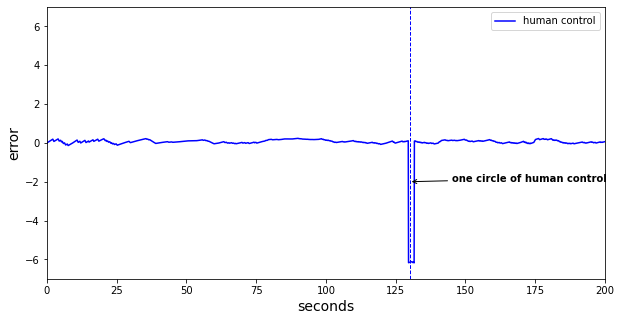

In [69]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(human_error.t, human_error.human_error, label = 'human control', color = 'blue')
ax.legend()
ax.set_xlim([0,200])
ax.set_ylim([-7,7])
ax.axvline(x = 130, linestyle = '--', color = 'blue',linewidth = 1)
ax.annotate('one circle of human control', (130,-2), (130+15,-2),'data',arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"), color = 'black',fontweight= 'bold')
ax.set_xlabel('seconds', fontsize = 14)
ax.set_ylabel('error', fontsize = 14)

Text(0, 0.5, 'error')

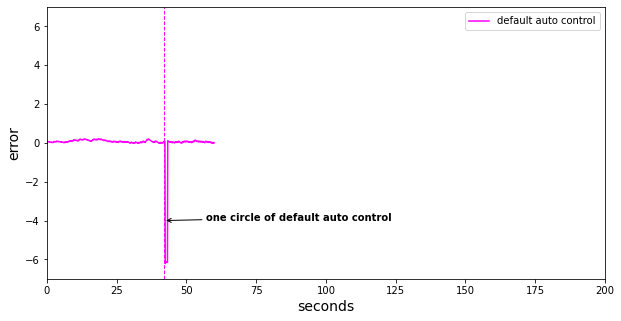

In [77]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (10,5))
ax.plot(de_error.t, de_error.default_auto_error, label = 'default auto control', color = 'magenta')
ax.legend()
ax.set_xlim([0,200])
ax.set_ylim([-7,7])
ax.axvline(x = 42, linestyle = '--', color = 'magenta',linewidth = 1)
ax.annotate('one circle of default auto control', (42,-4), (42+15,-4),'data',arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"), color = 'black',fontweight= 'bold')
ax.set_xlabel('seconds', fontsize = 14)
ax.set_ylabel('error', fontsize = 14)


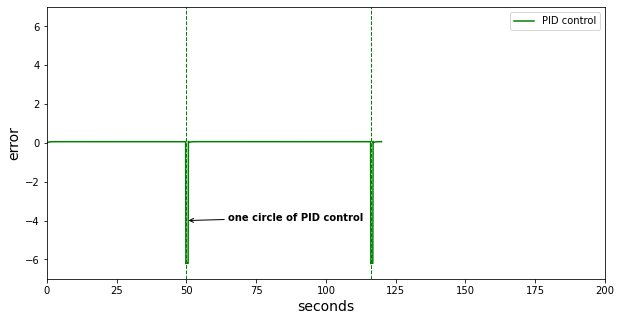

In [85]:
%matplotlib inline

fig, ax = plt.subplots(figsize = (10,5))
ax.plot(pid_error.t, pid_error.smart_error, label = 'PID control', color = 'green')
ax.legend()
ax.set_xlim([0,200])
ax.set_ylim([-7,7])
ax.axvline(x = 50, linestyle = '--', color = 'green',linewidth = 1)
ax.annotate('one circle of PID control', (50,-4), (50+15,-4),'data',arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"), color = 'black',fontweight= 'bold')
ax.set_xlabel('seconds', fontsize = 14)
ax.set_ylabel('error', fontsize = 14)
ax.axvline(x = 116, linestyle = '--', color = 'green',linewidth = 1)

Text(0, 0.5, 'error')

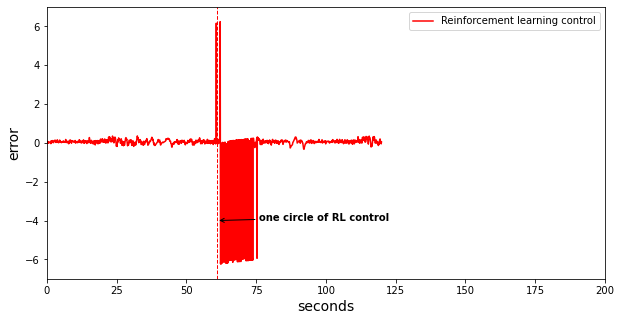

In [102]:
%matplotlib inline

fig, ax = plt.subplots(figsize = (10,5))
ax.plot(rl_error.t, rl_error.smart_error, label = 'Reinforcement learning control', color = 'red')
ax.legend()
ax.set_xlim([0,200])
ax.set_ylim([-7,7])
ax.axvline(x = 61, linestyle = '--', color = 'red',linewidth = 1)
ax.annotate('one circle of RL control', (61,-4), (61+15,-4),'data',arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"), color = 'black',fontweight= 'bold')
ax.set_xlabel('seconds', fontsize = 14)
ax.set_ylabel('error', fontsize = 14)



# plot all scenarios

In [113]:
%matplotlib qt
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (10,5))
ax.plot(rl_error.t, rl_error.smart_error,label = 'reinforcement learning', color = 'red')
ax.plot(pid_error.t, pid_error.smart_error,label = 'PID control', color = 'green')
ax.plot(human_error.t, human_error.human_error,label = 'human control',color = 'blue')
ax.plot(de_error.t, de_error.default_auto_error, label = 'default auto control', color = 'magenta')

ax.legend()
ax.set_xlim([0,200])
ax.set_ylim([-7,7])
ax.set_xlabel('seconds', fontsize = 14)
ax.set_ylabel('error', fontsize = 14)
ax.axvline(x = 61, linestyle = '--', color  = 'red',linewidth = 1)
ax.annotate('one circle of RL control', (61,3), (61+15,3),'data',arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"), color = 'black',fontweight= 'bold')

ax.axvline(x = 50,linestyle = '--', color = 'green',linewidth = 1)
ax.annotate('one circle of PID control', (50,2), (50+15, 2),'data',arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"), color = 'black',fontweight= 'bold')

ax.axvline(x = 116, linestyle = '--', color = 'green',linewidth = 1)
ax.axvline(x = 129, linestyle = '--', color = 'blue',linewidth = 1)
ax.annotate('one circle of human control', (129,-2), (129+15,-2),'data',arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"), color = 'black',fontweight= 'bold')

ax.axvline(x = 42, linestyle = '--', color = 'magenta',linewidth = 1)

ax.annotate('one circle of default auto control', (42,-2), (42+15,-2),'data',arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"), color = 'black',fontweight= 'bold')

Text(57, -2, 'one circle of default auto control')

# bonus questions.

In [191]:
def set_up_2():
    
    # set up a world and add elements to it. 
    # first layer is road, the last layer is car1. c1. 
    # for setting up 2 vehicles.
    
    dt = 0.1 # time steps in terms of seconds. In other words, 1/dt is the FPS.
    world_width = 120 # in meters
    world_height = 120
    inner_building_radius = 30
    num_lanes = 2
    lane_marker_width = 0.5
    num_of_lane_markers = 50
    lane_width = 3.5
    
    w = World(dt, width = world_width, height = world_height, ppm = 6) # The world is 120 meters by 120 meters. ppm is the pixels per meter.
    
    # To create a circular road, we will add a CircleBuilding and then a RingBuilding around it
    cb = CircleBuilding(Point(world_width/2, world_height/2), inner_building_radius, 'yellow')
    w.add(cb)
    rb = RingBuilding(Point(world_width/2, world_height/2), inner_building_radius + num_lanes * lane_width + (num_lanes - 1) * lane_marker_width, 1+np.sqrt((world_width/2)**2 + (world_height/2)**2), 'blue')
    w.add(rb)
    # w.render()
    # Let's also add some lane markers on the ground. This is just decorative. Because, why not.
    for lane_no in range(num_lanes - 1):
        lane_markers_radius = inner_building_radius + (lane_no + 1) * lane_width + (lane_no + 0.5) * lane_marker_width
        lane_marker_height = np.sqrt(2*(lane_markers_radius**2)*(1-np.cos((2*np.pi)/(2*num_of_lane_markers)))) # approximate the circle with a polygon and then use cosine theorem
        for theta in np.arange(0, 2*np.pi, 2*np.pi / num_of_lane_markers):
            dx = lane_markers_radius * np.cos(theta)
            dy = lane_markers_radius * np.sin(theta)
            w.add(Painting(Point(world_width/2 + dx, world_height/2 + dy), Point(lane_marker_width, lane_marker_height), 'white', heading = theta))
    
    # A Car object is a dynamic object -- it can move. We construct it using its center location and heading angle.
    c1 = Car(Point(91.75,60), np.pi/2)  # center of car.
    c1.max_speed = 30.0 # let's say the maximum is 30 m/s (108 km/h)
    c1.velocity = Point(0, 3.0)  # this is xp, yp
    w.add(c1)
    
    c2 = Car(Point(91.75 + lane_width, 60), np.pi/2,'orange')
    c2.max_speed = 30.0
    c2.velocity = Point(0,3.0)
    w.add(c2)
    
    w.render() # This visualizes the world we just constructed.
    
    print("the elements of the simulated world: \n", w.agents)
    
    return w

In [192]:
def lane_change(car, rb, desired_lane):
    
    '''
    used to formulate the lane change behavior
    rb: ringbuilding object
    car: car object
    '''
    lp = 0
    
    if car.distanceTo(cb) < desired_lane * (lane_width + lane_marker_width) + 0.2:
        lp += 0. # closet to circle
    elif car.distanceTo(rb) < (num_lanes - desired_lane - 1) * (lane_width + lane_marker_width) + 0.3:
        lp += 1. # leave to bounrdary
             
    #  update heading 
    v = car.center - cb.center
    v = np.mod(np.arctan2(v.y, v.x) + np.pi/2, 2*np.pi)
    err1 = v - car.heading
    
    
    if car.heading < v:
        lp += 0.7
    else:
        lp += 0.

    if np.random.rand() < lp: car.set_control(0.2, 0.1)
        
    else: car.set_control(-0.1, 0.1)
    
    return None
    

In [236]:
def run_simualtion_2(w, learning_approach):

    
    ''' for two vehicles.
    :args
        w -> the object of world
        learning_approach --> either human_controll, pid_controll, or rl_controll
    '''
    c1 = w.agents[-2]
    c2 = w.agents[-1]
    cb = w.agents[0]
    rb =  w.agents[1]
    
    dt = 0.1  # time steps in terms of seconds. In other words, 1/dt is the FPS.
    world_width = 120 # in meters
    world_height = 120
    inner_building_radius = 30
    num_lanes = 2
    lane_marker_width = 0.5
    num_of_lane_markers = 50
    lane_width = 3.5
    smart_error = [] # record error
    
    if learning_approach == 'default_auto':
        
        desired_lane = 1
       
        for k in range(1200):
            
            
            lane_change( car = c1, rb= rb, desired_lane = D1)
            lane_change( car = c2, rb= rb, desired_lane = D2)  # lane is from outer to inner.

            w.tick() # This ticks the world for one time step (dt second)
            w.render()
            time.sleep(dt/4) # Let's watch it 4x

            if w.collision_exists(): # We can check if there is any collision at all.
                print('Collision exists somewhere...', end = '\r')
                
#         smart_error = pd.DataFrame(smart_error, columns = ['t','default_auto_error'])
#         smart_error.to_csv('../errors/default_auto-{:.0f}.csv'.format(time.time()))

In [238]:
w = set_up_2()

the elements of the simulated world: 
 [<agents.CircleBuilding object at 0x26730538>, <agents.RingBuilding object at 0x26730700>, <agents.Painting object at 0x29C442E0>, <agents.Painting object at 0x29C44E80>, <agents.Painting object at 0x29C44268>, <agents.Painting object at 0x29C44B38>, <agents.Painting object at 0x29C44EB0>, <agents.Painting object at 0x29BACF88>, <agents.Painting object at 0x2BC89760>, <agents.Painting object at 0x29C1B0E8>, <agents.Painting object at 0x29C1B388>, <agents.Painting object at 0x29C1B550>, <agents.Painting object at 0x29C1B778>, <agents.Painting object at 0x29C1B940>, <agents.Painting object at 0x29C1BA90>, <agents.Painting object at 0x29C1BC58>, <agents.Painting object at 0x29C1BD00>, <agents.Painting object at 0x29C1BDD8>, <agents.Painting object at 0x29C1BDC0>, <agents.Painting object at 0x29C5CB68>, <agents.Painting object at 0x29C5CE80>, <agents.Painting object at 0x29C5C508>, <agents.Painting object at 0x29C5C0B8>, <agents.Painting object at 0x2

In [239]:
run_simualtion_2(w, 'default_auto')
w.close()

In [241]:
w.close()

In [164]:
w.agents[-2]